In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from qiime2 import Artifact
from skbio.stats.ordination import OrdinationResults

%matplotlib inline

In [3]:
! qiime diversity core-metrics-phylogenetic \
--i-table Data/noMito_noChloro-filtered-table.qza \
--i-phylogeny Data/insertion-tree.qza \
--p-sampling-depth 10843 \
--m-metadata-file Data/IBS-metadata.txt \
--output-dir Data/core-metrics-results

Saved FeatureTable[Frequency] to: Data/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Data/core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: Data/core-metrics-results/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Data/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Data/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix to: Data/core-metrics-results/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: Data/core-metrics-results/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: Data/core-metrics-results/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Data/core-metrics-results/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Data/core-metrics-results/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: Data/core-metrics-results/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: Data/core-metrics-results/jaccard_pcoa_results.qza
Sa

In [55]:
u_uni_pcoa = Artifact.load("Data/core-metrics-results/unweighted_unifrac_pcoa_results.qza").view(OrdinationResults)
metadata = pd.read_csv("Data/IBS-metadata.txt", sep="\t", index_col="Sampleid")

u_uni_plotdata = u_uni_pcoa.samples
u_uni_plotdata = u_uni_plotdata.reindex(metadata.index)
u_uni_plotdata["IBS"] = metadata["IBS"].apply(lambda x: "Healthy Control" if x=="N" else "IBS")
u_uni_plotdata["IBS Type"] = metadata["IBS Type"].apply(lambda x: "Control" if x=="control" else x)

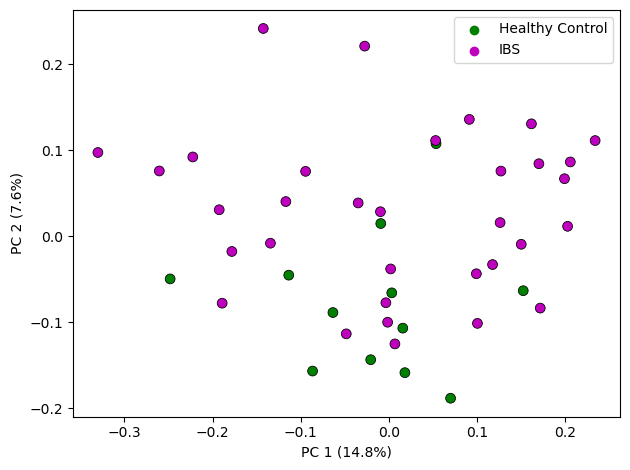

In [63]:
ax = sns.scatterplot(x=0, y=1, 
                    hue="IBS", 
                    palette=["g","m"],
                    data=u_uni_plotdata,
                    edgecolor="black",
                    s=50)
ax.set_xlabel(f"PC 1 ({round(u_uni_pcoa.proportion_explained[0]*100,1)}%)")
ax.set_ylabel(f"PC 2 ({round(u_uni_pcoa.proportion_explained[1]*100,1)}%)")
ax.legend(title=None)

plt.tight_layout()
plt.savefig("Figures/u_uni_IBS_pcoa.pdf")
plt.show()


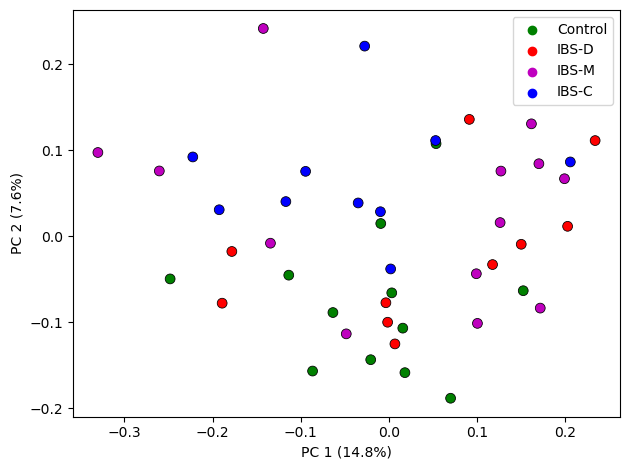

In [62]:
ax = sns.scatterplot(x=0, y=1, 
                    hue="IBS Type", 
                    hue_order=["Control","IBS-D","IBS-M","IBS-C"],
                    palette=["g","r","m","b"],
                    data=u_uni_plotdata,
                    edgecolor="black",
                    s=50)
ax.set_xlabel(f"PC 1 ({round(u_uni_pcoa.proportion_explained[0]*100,1)}%)")
ax.set_ylabel(f"PC 2 ({round(u_uni_pcoa.proportion_explained[1]*100,1)}%)")
ax.legend(title=None)

plt.tight_layout()

plt.savefig("Figures/u_uni_subtypes_pcoa.pdf")
plt.show()
